In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import quad, solve_ivp
%matplotlib inline

# Question 2 --- Parallel flow utility

In [3]:
# variables
q = 110 # m3.s-1
Ti = 800 # K
Tf = 977 # K
Dp = np.mean([0.25, 0.42])*1e-3 # particle diameter
utility = 'air' # <--- choose utility type ('steam'/'co2'/'air')

# parameters
V = 10 # m3

In [4]:
# gas properties
μ_eb = lambda T: -5.5691 + 0.239*T - 2.9063e-5*T**2 # μP
μ_sty = lambda T: -10.2504038379892 + 0.253355736718692*T - 4.05863683702377E-05*T**2 + 1.42363548953527E-09*T**3 # μP
μ_h = lambda T: 1.797e-07*T**0.685/(1 + -0.59/T + 140/T**2)*1e6*1e1 # μP
μ_b = lambda T: -0.1509 + 0.2571*T - 8.9797E-06*T**2 # μP
μ_e = lambda T: -3.9851 + 0.3873*T - 1.1227E-04**T # μP
μ_t = lambda T: 1.7869 + 0.2357*T - 9.3508E-06*T**2 # μP
μ_m = lambda T: 3.8435 + 0.4011*T - 1.4303E-04*T**2 # μP
μ_ste = lambda T: 1.7096E-08*T**1.1146/1*1e6*1e1 # μP

μi_arr = np.array([μ_eb(Ti), μ_sty(Ti), μ_h(Ti), μ_b(Ti), μ_e(Ti), μ_t(Ti), μ_m(Ti), μ_ste(Ti)])
μf_arr = np.array([μ_eb(Tf), μ_sty(Tf), μ_h(Tf), μ_b(Tf), μ_e(Tf), μ_t(Tf), μ_m(Tf), μ_ste(Tf)])
xi_arr = np.array([0.06451612903225806, 0, 0, 0, 0, 0, 0, 0.935483870967742])
xf_arr = np.array([0.0010872815738315336, 0.0393132492365476, 0.035104722184370496, 0.01631796084205036, 0.01631796084205036, 0.004208527052177091, 0.004208527052177091, 0.8834417712167955])
k_maxT = [0.019, 0.0083, 0.42, 0.0129, 0.007, 0.0159, 0.11933, 0.06677]

def utility_properties(utility):
    if (utility == 'air'):
        return [0.3666, 4.269e-5, 0.06868, 0.7128] # ρ, μ, k, Pr
    if (utility == 'co2'):
        return [0.5505, 4.195e-5, 0.06974, 0.7457]
    if (utility == 'steam'):
        return [0.2254, 3.854e-5, 0.10329, 0.8861]

In [5]:
Dto_list = np.array([17.2, 21.3, 26.9, 33.7, 42.4, 48.3, 60.3, 76.1, 88.9, 114.3, 139.7, 165.1, 219.1, 273, 323.9, 355.6, 406.4, 508, 610, 711])*1e-3
Nt_list = np.arange(1, 1000 + 10, 10)

result = []
for Dto in Dto_list:    
    for Nt in Nt_list:
        Dti = Dto - 2e-3 # tube inner diameter
        St = 2*Dto # m
        
        # Check
        A = Nt*np.pi/4*Dti**2
        L = V/A
        if (Nt == 1):
            Dtot = St
        else:
            Dtot = np.sqrt(4/np.pi*Nt*St**2)
        heur = L/Dtot
        if (heur >= 3) and (heur <= 5):
            # external
            #---------------------------------
            u = q/(np.pi/4*(Dtot**2 - Nt*Dto**2))
            ϵ = 0.046e-3 # m
            ρ, μ, k, Pr = utility_properties(utility)

            Dh = Dtot - Dto
            Re = Dh*u*ρ/(μ)
            f = (-1.8*np.log10((ϵ/Dto/3.7)**1.11 + 6.9/Re))**(-2)

            # gnielisnki equation
            Nu = (f/8)*(Re - 1000)*Pr/(1 + 12.7*(f/8)**0.5*(Pr**(2/3) - 1)) # valid for 0.5 < Pr < 2000 and 3e3 < Re < 5e6, properties at bulk mean fluid temperature
            F = 0.86*(Dto/Dtot)**(-0.16)
            Nu = Nu*F
            h_external = Nu*k/Dh


            # internal
            #---------------------------------
            # variables
            G = (0.00344*106.167 + 14.5*0.00344*18)/(np.pi/4*Dti**2)/Nt # mass flux
            μ = np.mean([sum(μi_arr*xi_arr), sum(μf_arr*xf_arr)])*1e-7 # gas viscosity
            k = np.mean([sum(k_maxT*xi_arr), sum(k_maxT*xf_arr)]) # average thermal conductivity of gas [btu.hr-1.F-1.ft-1]

            # conversions
            Dti_imp = Dti*3.28084 # ft
            Dp_imp = Dp*3.28084 # ft
            G_imp = G*737.338117 #[lb.ft-2.hr-1]
            μ_imp = μ*2419.088153749502 # gas viscosity [lb.hr-1.ft-1]
            k_imp = k*0.5781759824 # average thermal conductivity of gas [btu.hr-1.F-1.ft-1]

            h_internal_imp = 0.813*k_imp/Dti_imp*np.exp(-6*Dp_imp/Dti_imp)*(Dp_imp*G_imp/μ_imp)**0.9
            h_internal = h_internal_imp*5.678263

            # overall
            #---------------------------------
            U = (1/h_internal + 1/h_external)**(-1)

            a = 4/Dti
            Ua = U*a
            
            result.append([Nt, Dto, Ua])


Max Ua value = 1248.6325705418294 at Dto = 0.0424 and Nt = 651.0



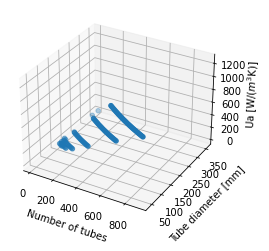

In [6]:
X, Y, Z = np.array(result).T

ax = plt.axes(projection='3d')
ax.scatter(X, Y*1e3, Z)
ax.set_xlabel('Number of tubes')
ax.set_ylabel('Tube diameter [mm]')
ax.set_zlabel('Ua [W/($m^{3}$K)]')

# # tube length
# UA_max = max(Z)
# Dti_max = Y[Z == max(Z)] - 2e-3
# Nt_max = X[Z == max(Z)]
# L = V/(Nt_max*np.pi/4*Dti_max)

print(f'Max Ua value = {max(Z)} at Dto = {Y[Z==max(Z)][0]} and Nt = {X[Z==max(Z)][0]}')
print(f'')